# Chapter 2 (End-to-End Machine Learning Project)


### Steps:

1. Look at the big picture
2. Get the data
3. Discover and visualize the data to gain insights
4. Prepare the data for Machine Learning algorithms
5. Select a model and train it
6. Fine-tune your model
7. Present your solution
8. Launch, monitor, and maintain your system

## Predicting house prices


You should use the Machine Learning Project checklist (https://github.com/ageron/handson-ml/blob/master/ml-project-checklist.md) this works for most ML projects but you may need to adapt it to your needs.


### Frame the problem
Define your business objective. How does the company expect to use and benefit from this model? This will determine how you frame the problem, what algorithms you will select, what performance measure you will use to evaluate your model and how much effort you should spend tweaking it.




### Pipelines (Don't worry about this right now)

A sequence of data processing components are called a data pipline. Components run asynchronously. Each component pulls in a large amount of data, processes it, and spits out the result in another data store, and then some time later the next component in the pipline pulls this data and spits out it own output and so on.


### Evaluating the current solution

The next question to ask is what the current solution looks like. 

### Design of the system

First you need to frame the problem: is it supervised, unsupervised, or Reinforcement Learning? Is it a classification taks, a regression task, or something else? Should you use batch learning or online learning techniques?



### Select a performance measure

For our scenario since we are working with a regression problem we will use the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in it's predictions.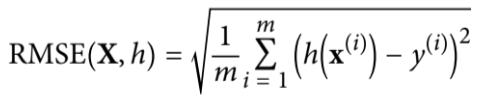



M = size of dataset i.e. the number of instances in the dataset you are measuring


x(i) = is a vector of all the feature values (excluding the label). For example if the first district in the dataset is located at longitutde -118.29°, latitude 33.91°, and it has 1,416 inhabitants with a median income of 38,372 and the median house value is $156,400 then






$x^{(1)}$ = \begin{pmatrix}
-118.29\\
33.91\\
1,416\\
38,372\\
\end{pmatrix}





h = The system's predictor function, also called hypothesis. ŷ(i) = h(x(i))


RMSE(X,h) is the cost function measured on the set of examples using your hypothesis h.



### Check the Assumptions

It's a good practice to list and verify the assumptions that were made so far (by you or others), this can catch serious issues early on. 


## Download the Data

In [ ]:
import os
import tarfile
from six.moves import urllib

import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"

# HOUSING_PATH = datasets/housing
HOUSING_PATH = os.path.join("datasets", "housing")

HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data(HOUSING_URL, HOUSING_PATH)


## Loading the data in pandas

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Analyzing

In [ ]:
housing = load_housing_data()
housing.head()

In [ ]:
housing.info()

<i>Notice that the total_bedrooms attributes has only 20,443 non null values meaning that 207 districts are missing this feature.
    
    
All attributes are numerical, expect the ocean_proximity field. It is type object. You can see that it's a categorical attribute since it's values are repetitive in one of the tables.

In [ ]:
housing["ocean_proximity"].value_counts()

The describe() method shows a summary of the numerical attributes.

In [ ]:
housing.describe()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Analysis of the data


1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000). Working with preprocessed attributes is common in Machine Learning, Get the Data and it is not necessarily a problem, but you should try to understand how the data was computed.


2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team to see if this is a problem or not. If they tell you that they need precise pre‐dictions even beyond $500,000, then you have mainly two options:
    a. Collect proper labels for the districts whose labels were capped.
    b. Remove those districts from the training set

3. These attributes have very different scales i.e. they've been feature scaled. 

4. Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

## Creating a test set


Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside.

For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will
not contain any instance that was previously in the training set. Here is a possible implementation:

In [ ]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    print(shuffled_indices)
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]



In [ ]:
train_set, test_set = split_train_test(housing, 0.2)

In [ ]:
len(train_set)

In [ ]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [ ]:
housing_with_id = housing.reset_index()

In [ ]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. An alternative is to find a property in your database that unique to each row, i.e. in the case of housing we can use the latitude and longitude. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [ ]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

<b>Scikit-Learn</b> provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split, which does pretty much the same thing as the function split_train_test defined earlier, with a couple of additional features. First there is a random_state parameter that allows you to set the random generator seed as explained previously, and second you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

If your dataset is not large enough like the housing set, you run the risk of introducing a significant sampling bias. For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would
try to maintain this ratio in the sample: 513 female and 487 male. If they used purely random sampling, there would be about 12% chance of sampling a skewed test set with either less than 49% female or more than 54% female. Either way, the survey results would be significantly biased.

Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute.


Let’s look at the median income histogram above more closely most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased.

The code below creates an income category attribute with 5 categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1,2,3,4,5])

In [ ]:
housing["income_cat"].hist()

Stratified sampling based on income category. For this you can use Scikit-Learn’s StratifiedShuffleSplit class:

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

Now you should remove the income_cat attribute so the data is back to its original state:

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights



First, make sure you have put the test set aside and you are only exploring the training set.

Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so you can just work directly on the full set. Let’s create a copy so you can play with it without harming the training set:

In [ ]:
housing = strat_train_set.copy()

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

In [ ]:
%matplotlib inline  
import matplotlib.pyplot as plt

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing["population"]/100, label="population", figsize=(10,7), 
             c="median_house_value", cmap="jet", colorbar=True)


plt.legend()

## Looking for Correlations

Since the dataset is not too large, you can easily compute the standard correlation coefficient

In [ ]:
corr_matrix = housing.corr(numeric_only = True)
corr_matrix["median_house_value"].sort_values(ascending=False)

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation
between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north).

Another way to check for correlation between attributes is to use Pandas’ scatter_matrix function, which plots every numerical attribute against every other numerical attribute.

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12,8))

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000.

But this plot reveals other less obvious straight lines: a horizontal line around $450,000, another around $350,000, perhaps one around $280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

One last thing you may want to do before actually preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [ ]:
corr_matrix = housing.corr(numeric_only = True)
corr_matrix["median_house_value"].sort_values(ascending=False)

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first rea‐ sonably good prototype. But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

## Prepare the data for machine learning algorithms

First let’s revert to a clean training set and let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. You noticed earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:

- Get rid of the corresponding districts
- Get rid of the whole attribute
- Set the values to some value (zero, the mean, the median, etc.)


You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna() methods:

In [ ]:
housing.dropna(subset=["total_bedrooms"])   # Option 1
housing.drop("total_bedrooms", axis=1)      # Option 2
median = housing["total_bedrooms"].median() # Option 3

Scikit-Learn provides a handy class to take care of missing values: SimpleImputer. Here is how to use it. First, you need to create a SimpleImputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

The median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity:

In [ ]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [ ]:
imputer.fit(housing_num) # Fit the imputer instance to the training data

In [ ]:
imputer.statistics_
# housing_num.median().values

Now you can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Handling Text and Categorical Attributes

Earlier we left out the categorical attribute ocean_proximity because it is a text attribute so we cannot compute its median. Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s OrdinalEncoder class.

In [ ]:
housing_cat = housing[["ocean_proximity"]]
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

You can get the list of categories using the categories_ instance variable. It is a list containing a 1D array of categories for each categorical attribute

In [ ]:
ordinal_encoder.categories_

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1).

To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for a single 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the non‐zero elements. You can use it mostly like a normal 2D array, but if you really want to convert it to a (dense) NumPy array, just call the toarray() method:

In [ ]:
housing_cat_1hot.toarray()

## Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn func‐tionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inher‐itance), all you need is to create a class and implement three methods: fit() (returning self), transform(), and fit_transform().


You can get the last one for free by simply adding TransformerMixin as a base class. Also, if you add BaseEstima
tor as a base class (and avoid *args and ** kargs in your constructor) you will get two extra methods (get_params() and set_params()) that will be useful for auto‐matic hyperparameter tuning.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_rooms = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, 
                        bedrooms_per_rooms]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

## Feature Scaling


One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15.



There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

Min-max scaling (many people call this normalization) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if you don’t want 0–1 for some reason.


Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization.


<b>As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).</b>

## Transformation Pipelines

There are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations. All but the last estimator must be transformers (i.e., they must have a fit_transform() method).

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])


housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipline.fit_transform(housing)

In this example, we specify that the numerical columns should be transformed using the num_pipeline that we defined earlier, and the categorical columns should be transformed using a OneHotEncoder. Finally, we apply this ColumnTransformer to the housing data: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

## Select and Train a Model

### Training and Evaluating on the Training Set

Let's first train a Linear Regression mode

In [ ]:
from sklearn.linear_model import LinearRegression


lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

Done! You now have a working Linear Regression model. Let’s try it out on a few instances from the training set:

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))

print("Labels: ", list(some_labels))

It works, although the predictions are not exactly accurate (e.g., the first prediction is off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error function:

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

Okay, this is better than nothing but clearly not a great score: most districts’ median_housing_values range between $120,000 and $265,000, so a typical prediction error of $68,628 is not very satisfying. This is an example of a model underfitting the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model.



This model is not regularized, so this rules out the last option. You could try to add more features (e.g., the log of the population), but first let’s try a more complex model to see how it does.


Use a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_mse = np.sqrt(tree_mse)
tree_mse

No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure?

As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training, and part for model validation.

### Better Evaluation Using Cross-Validation

One way to evaluate the Decision Tree model would be to use the train_test_split function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult and it would work fairly well.


A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)


def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation).


Now the Decision Tree doesn’t look as good as it did earlier. The Decision Tree has a score of approximately 71,407, generally ±2,439. The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model which had a score of 68627.


Let’s try one last model now: the RandomForestRegressor. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel="linear")
clf.fit(housing_prepared, housing_labels)

svm_prediction = clf.predict(housing_prepared)
print(svm_prediction)

You should save every model you experiment with, so you can come back easily to any model you want. Make sure you save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to easily compare scores across model types, and compare the types of errors they make.

In [ ]:
from sklearn.externals import joblib

joblib.dump(my_model, "my_model.pkl")
my_model_loaded = joblib.load("my_model.pkl")

## Fine-Tune Your Model



### Grid Search
All you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

When you have no idea what value a hyperparameter should have, a simple approach is to try out consecutive powers of 10.


This param_grid tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of n_estimators and max_features hyperparameter values specified in the first dict. Then try all 2 × 3 = 6 combinations of hyperparameter values in the
second dict, but this time with the bootstrap hyperparameter set to False instead of True.

All in all, the grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor hyperparameter values, and it will train each model five times.

You can get the best combination of parameters like this:

In [ ]:
grid_search.best_params_

If GridSearchCV is initialized with refit=True then once it finds the best estimator using cross- validation, it retrains it on the whole training set. This is usually a good idea since feeding it more data will likely improve its performance.